In [30]:
# import 
import numpy as np
import matplotlib.pyplot as plt
import profiles as pr
import galhalo as gh
import config as cfg

In [31]:
# plot control
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.labelsize'] = 18

In [32]:
# define cross section model
sigma0 = 5 #[cm^2/g]
omega = 250 #[km/s]
Vmax_range = [10,5000] #[km/s]

# create an interpolation function 
sigmaeff_intep = pr.create_sigmaeff_vmax_interpolation(Vmax_range,sigma0,omega)[0]

In [33]:
# define halo parameters
lgMv = 12
c = 10
tage = 10 #[Gyr]
lgMb = 10
a = 4

# define objects
halo_init = pr.NFW(10.**lgMv,c)
disk = pr.Hernquist(10.**lgMb,a)
rv = halo_init.rh
r_full = np.logspace(-3,np.log10(rv),300)

# compute effective cross section
Vmax = halo_init.Vmax
sigmaeff = sigmaeff_intep(Vmax) #Note that here we use Vmax of the initial NFW halo
product = tage*sigmaeff

# compute adiabatic contraction of the initial CDM halo
Mcontra_interp = gh.contra_general_Minterp(r_full,halo_init,disk)[0]

In [ ]:
# calculate tmerge
# This step takes a second, we suggest you pre-compute
# a table to interpolate tmerge.
t_merge,product_merge = pr.tmerge(halo_init,disk)

# calculate rhodm0_merge
# We suggest you pre-compute a table to interpolate rhodm0_merge.
rhodm0_merge = pr._compute_rhodm0_merge(halo_init,disk,product_merge)

# calculate r1 and calculate density and enclosed mass at r1
# If you input a disk object, adiabatic contraction will be considered.
# Note that in this step you NEED to mirror the product about
# product_merge if p > product_merge.
if product < product_merge:
    # Here we can let sigmamx=sigmaeff, tage=tage
    # or let sigmamx=1, tage=product
    r1,rho1,M1 = pr.r1(halo_init,sigmamx=1,tage=product,disk=disk) 
elif product >= 2*product_merge:
    print("Product cannot larger than 2*product_merge!")
else:
    product_mirror = 2*product_merge - product
    r1,rho1,M1 = pr.r1(halo_init,sigmamx=1,tage=product_merge,disk=disk) 

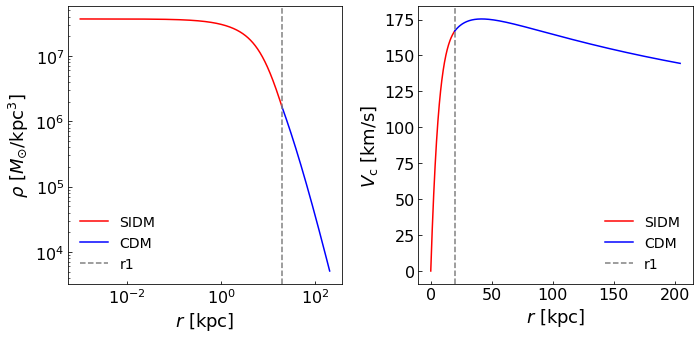

In [35]:
# compute the SIDM density profile

# SIDM inner halo
# use function stitchSIDMcore_given_pmerge (suggested)
# Note that in this step, do NOT mirror the product.
# We suggest you pre-compute a table for rhodm0_merge
# using the function pr._compute_rhodm0_merge, and input
# rhodm0_merge. Working without rhomerge input is also
# OK, but it will be slower.
rhodm0,v0,rho_iso_arr,Vc_iso_arr,r_iso_arr,_,_,_ = pr.stitchSIDMcore_given_pmerge(r1,
                                                     rho1,M1,halo_init,disk,product,product_merge,
                                                     rhomerge=None)
Vc_iso_arr = Vc_iso_arr*0.978462 #[km/s]

# CDM outskirt
r_cdm_arr = np.logspace(np.log10(r1),np.log10(rv),500)
rho_cdm_arr = gh.rho_GivenInterpMass(r_cdm_arr,Mcontra_interp)
Vc_cdm_arr = np.sqrt(cfg.G*Mcontra_interp(r_cdm_arr)/r_cdm_arr)*0.978462 #[km/s]

# plot
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(r_iso_arr,rho_iso_arr,label='SIDM',c='r')
axes[0].plot(r_cdm_arr,rho_cdm_arr,label='CDM',c='b')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel(r'$r$ [kpc]')
axes[0].set_ylabel(r'$\rho$ [$M_{\odot}$/kpc$^3$]')
axes[0].axvline(x=r1,ls='--',c='gray',label='r1')

axes[1].plot(r_iso_arr,Vc_iso_arr,label='SIDM',c='r')
axes[1].plot(r_cdm_arr,Vc_cdm_arr,label='CDM',c='b')
axes[1].set_xlabel(r'$r$ [kpc]')
axes[1].set_ylabel(r'$V_{\mathrm{c}}$ [km/s]')
axes[1].axvline(x=r1,ls='--',c='gray',label='r1')

axes[0].legend(loc='lower left',frameon=False)
axes[1].legend(loc='lower right',frameon=False)
plt.tight_layout()
plt.show()

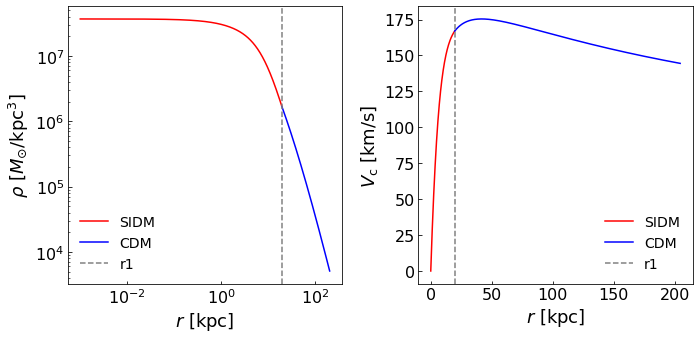

In [ ]:
# compute the SIDM density profile

# SIDM inner halo
# use function stitchSIDMcore2 
# sol1,sol2 is low- and high-density solution respectively.
sol1,sol2 = pr.stitchSIDMcore2(r1,rho1,M1,halo_init,disk=disk)[:2]
sol = sol1 if product < product_merge else sol2
rhodm0,v0,rho_iso_arr,Vc_iso_arr,r_iso_arr,_,_,_ = sol
Vc_iso_arr = Vc_iso_arr*0.978462 #[km/s]

# CDM outskirt
r_cdm_arr = np.logspace(np.log10(r1),np.log10(rv),500)
rho_cdm_arr = gh.rho_GivenInterpMass(r_cdm_arr,Mcontra_interp)
Vc_cdm_arr = np.sqrt(cfg.G*Mcontra_interp(r_cdm_arr)/r_cdm_arr)*0.978462 #[km/s]

# plot
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(r_iso_arr,rho_iso_arr,label='SIDM',c='r')
axes[0].plot(r_cdm_arr,rho_cdm_arr,label='CDM',c='b')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel(r'$r$ [kpc]')
axes[0].set_ylabel(r'$\rho$ [$M_{\odot}$/kpc$^3$]')
axes[0].axvline(x=r1,ls='--',c='gray',label='r1')

axes[1].plot(r_iso_arr,Vc_iso_arr,label='SIDM',c='r')
axes[1].plot(r_cdm_arr,Vc_cdm_arr,label='CDM',c='b')
axes[1].set_xlabel(r'$r$ [kpc]')
axes[1].set_ylabel(r'$V_{\mathrm{c}}$ [km/s]')
axes[1].axvline(x=r1,ls='--',c='gray',label='r1')

axes[0].legend(loc='lower left',frameon=False)
axes[1].legend(loc='lower right',frameon=False)
plt.tight_layout()
plt.show()